In [8]:
# Import Libraries and Setup
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

# Set plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)

In [9]:
# Load Dataset
iris = load_iris()
X = iris.data
true_labels = iris.target

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(true_labels))}")
print(f"Feature names: {iris.feature_names}")

Dataset shape: (150, 4)
Number of classes: 3
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [10]:
#K-Means Implementation
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)
kmeans_nmi = normalized_mutual_info_score(true_labels, kmeans_labels)

print(f"K-Means ARI: {kmeans_ari:.4f}")
print(f"K-Means NMI: {kmeans_nmi:.4f}")

K-Means ARI: 0.7163
K-Means NMI: 0.7419


In [11]:
#K-Random Forest Class
class KRandomForests:
    def __init__(self, n_clusters=3, n_estimators=100, max_iter=10, random_state=None):
        self.n_clusters = n_clusters
        self.n_estimators = n_estimators
        self.max_iter = max_iter
        self.random_state = random_state
        self.forests = [None] * self.n_clusters
        self.labels_ = None

    def _fit_forests(self, X, labels):
        for k in range(self.n_clusters):
            cluster_data = X[labels == k]
            if len(cluster_data) == 0:
                self.forests[k] = None
                continue
            self.forests[k] = IsolationForest(
                n_estimators=self.n_estimators,
                random_state=self.random_state
            )
            self.forests[k].fit(cluster_data)

    def _compute_anomaly_scores(self, X):
        scores = np.zeros((X.shape[0], self.n_clusters))
        for k, forest in enumerate(self.forests):
            if forest is None:
                scores[:, k] = np.inf
            else:
                scores[:, k] = -forest.decision_function(X)
        return scores

    def fit(self, X):
        rng = np.random.RandomState(self.random_state)
        labels = rng.randint(0, self.n_clusters, X.shape[0])

        for iteration in range(self.max_iter):
            self._fit_forests(X, labels)
            scores = self._compute_anomaly_scores(X)
            new_labels = np.argmin(scores, axis=1)
            if np.array_equal(labels, new_labels):
                break
            labels = new_labels

        self.labels_ = labels
        return self

    def predict(self, X):
        scores = self._compute_anomaly_scores(X)
        return np.argmin(scores, axis=1)


In [12]:
# Train K-Random Forest
k_rf = KRandomForests(n_clusters=3, n_estimators=100, max_iter=10, random_state=42)
k_rf.fit(X)
k_rf_labels = k_rf.labels_

k_rf_ari = adjusted_rand_score(true_labels, k_rf_labels)
k_rf_nmi = normalized_mutual_info_score(true_labels, k_rf_labels)

print(f"K-Random Forest ARI: {k_rf_ari:.4f}")
print(f"K-Random Forest NMI: {k_rf_nmi:.4f}")


K-Random Forest ARI: 0.8459
K-Random Forest NMI: 0.8109


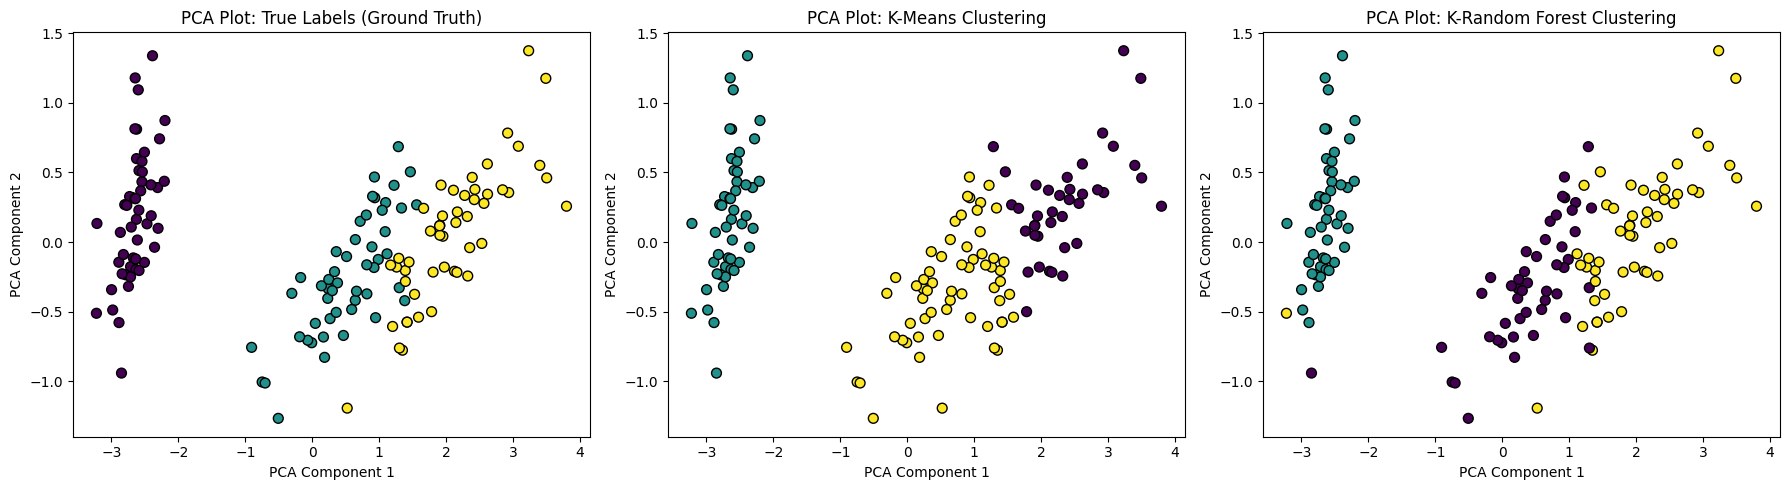

In [13]:
# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA Plot: True Labels (Ground Truth)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA Plot: K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=k_rf_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA Plot: K-Random Forest Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()


In [14]:
# Results Summary
results_df = pd.DataFrame({
    'Algorithm': ['K-Means', 'K-Random Forest'],
    'ARI': [kmeans_ari, k_rf_ari],
    'NMI': [kmeans_nmi, k_rf_nmi]
})

print("Clustering Comparison Results:")
display(results_df.round(4))

Clustering Comparison Results:


,Algorithm,ARI,NMI
0,K-Means,0.7163,0.7419
1,K-Random Forest,0.8459,0.8109
